In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, lubridate, zoo)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "lubridate"  TRUE  
[7,] "zoo"        TRUE  


# NYT county level time series 
https://github.com/nytimes/covid-19-data

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]

In [3]:
setorder(df, state, county, date)
df[,  `:=`(
  cfr = deaths/cases,
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
# clean up
df[ ,`:=`(new_deaths = ifelse(new_deaths < 0, 0, new_deaths),
          new_cases  = ifelse(new_cases < 0, 0, new_cases)
              )]
df = df[d >= "2020-03-01"]
rawvars = c("cases", "deaths", "new_cases", "new_deaths")

In [4]:
df[order(-date, -cases)][1:20]

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths
<chr>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>
2020-05-31,New York City,New York,NA,208085,21050,2020-05-31,0.10116,546,59
2020-05-31,Cook,Illinois,17031,77925,3642,2020-05-31,0.04674,806,39
2020-05-31,Los Angeles,California,6037,54996,2362,2020-05-31,0.04295,1345,24
2020-05-31,Nassau,New York,36059,40396,2615,2020-05-31,0.06473,89,0
2020-05-31,Suffolk,New York,36103,39643,1949,2020-05-31,0.04916,111,8
2020-05-31,Westchester,New York,36119,33480,1499,2020-05-31,0.04477,52,7
2020-05-31,Philadelphia,Pennsylvania,42101,22629,1316,2020-05-31,0.05816,0,8
2020-05-31,Middlesex,Massachusetts,25017,21287,1615,2020-05-31,0.07587,163,19
2020-05-31,Wayne,Michigan,26163,20415,2461,2020-05-31,0.12055,161,9


In [5]:
fwrite(df, 'data/nyt_county_level.csv')

### Rolling Mean Function

In [6]:
rollmeaneR = function(df, 
                      smoothvars = rawvars,
                      grouping = c("state", "county"),
                      sm_k = 5){
    f = copy(df)
    setorderv(f, cols = c(grouping, 'd'))
    f[, paste0("rm", "_", smoothvars) := lapply(.SD, rollmean, k = sm_k, fill = NA, na.pad = T), 
       by = grouping, .SDcols = smoothvars]
    return(f)
}

# Nationwide 

In [7]:
npan = df[, lapply(.SD, sum, na.rm = T), by = .(d), .SDcols = rawvars]
npan[, gr := 1]
npan[, cfr := deaths/cases]
npan = rollmeaneR(npan, c(rawvars, 'cfr'), grouping = "gr")
npan[, day := weekdays(d)]
npan[, weekend := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
npan[order(-d)][1:5]

d,cases,deaths,new_cases,new_deaths,gr,cfr,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths,rm_cfr,day,weekend
<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2020-05-31,1798764,104381,20838,614,1,0.05803,NA,NA,NA,NA,NA,Sunday,1
2020-05-30,1778129,103775,23757,976,1,0.05836,NA,NA,NA,NA,NA,Saturday,1
2020-05-29,1754735,102812,25032,1221,1,0.05859,1753912,102597,22372,1145,0.05850,Friday,0
2020-05-28,1730192,101621,22714,1241,1,0.05873,1731957,101508,22117,1178,0.05861,Thursday,0
2020-05-27,1707739,100397,19521,1674,1,0.05879,1710351,100386,21325,1090,0.05869,Wednesday,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


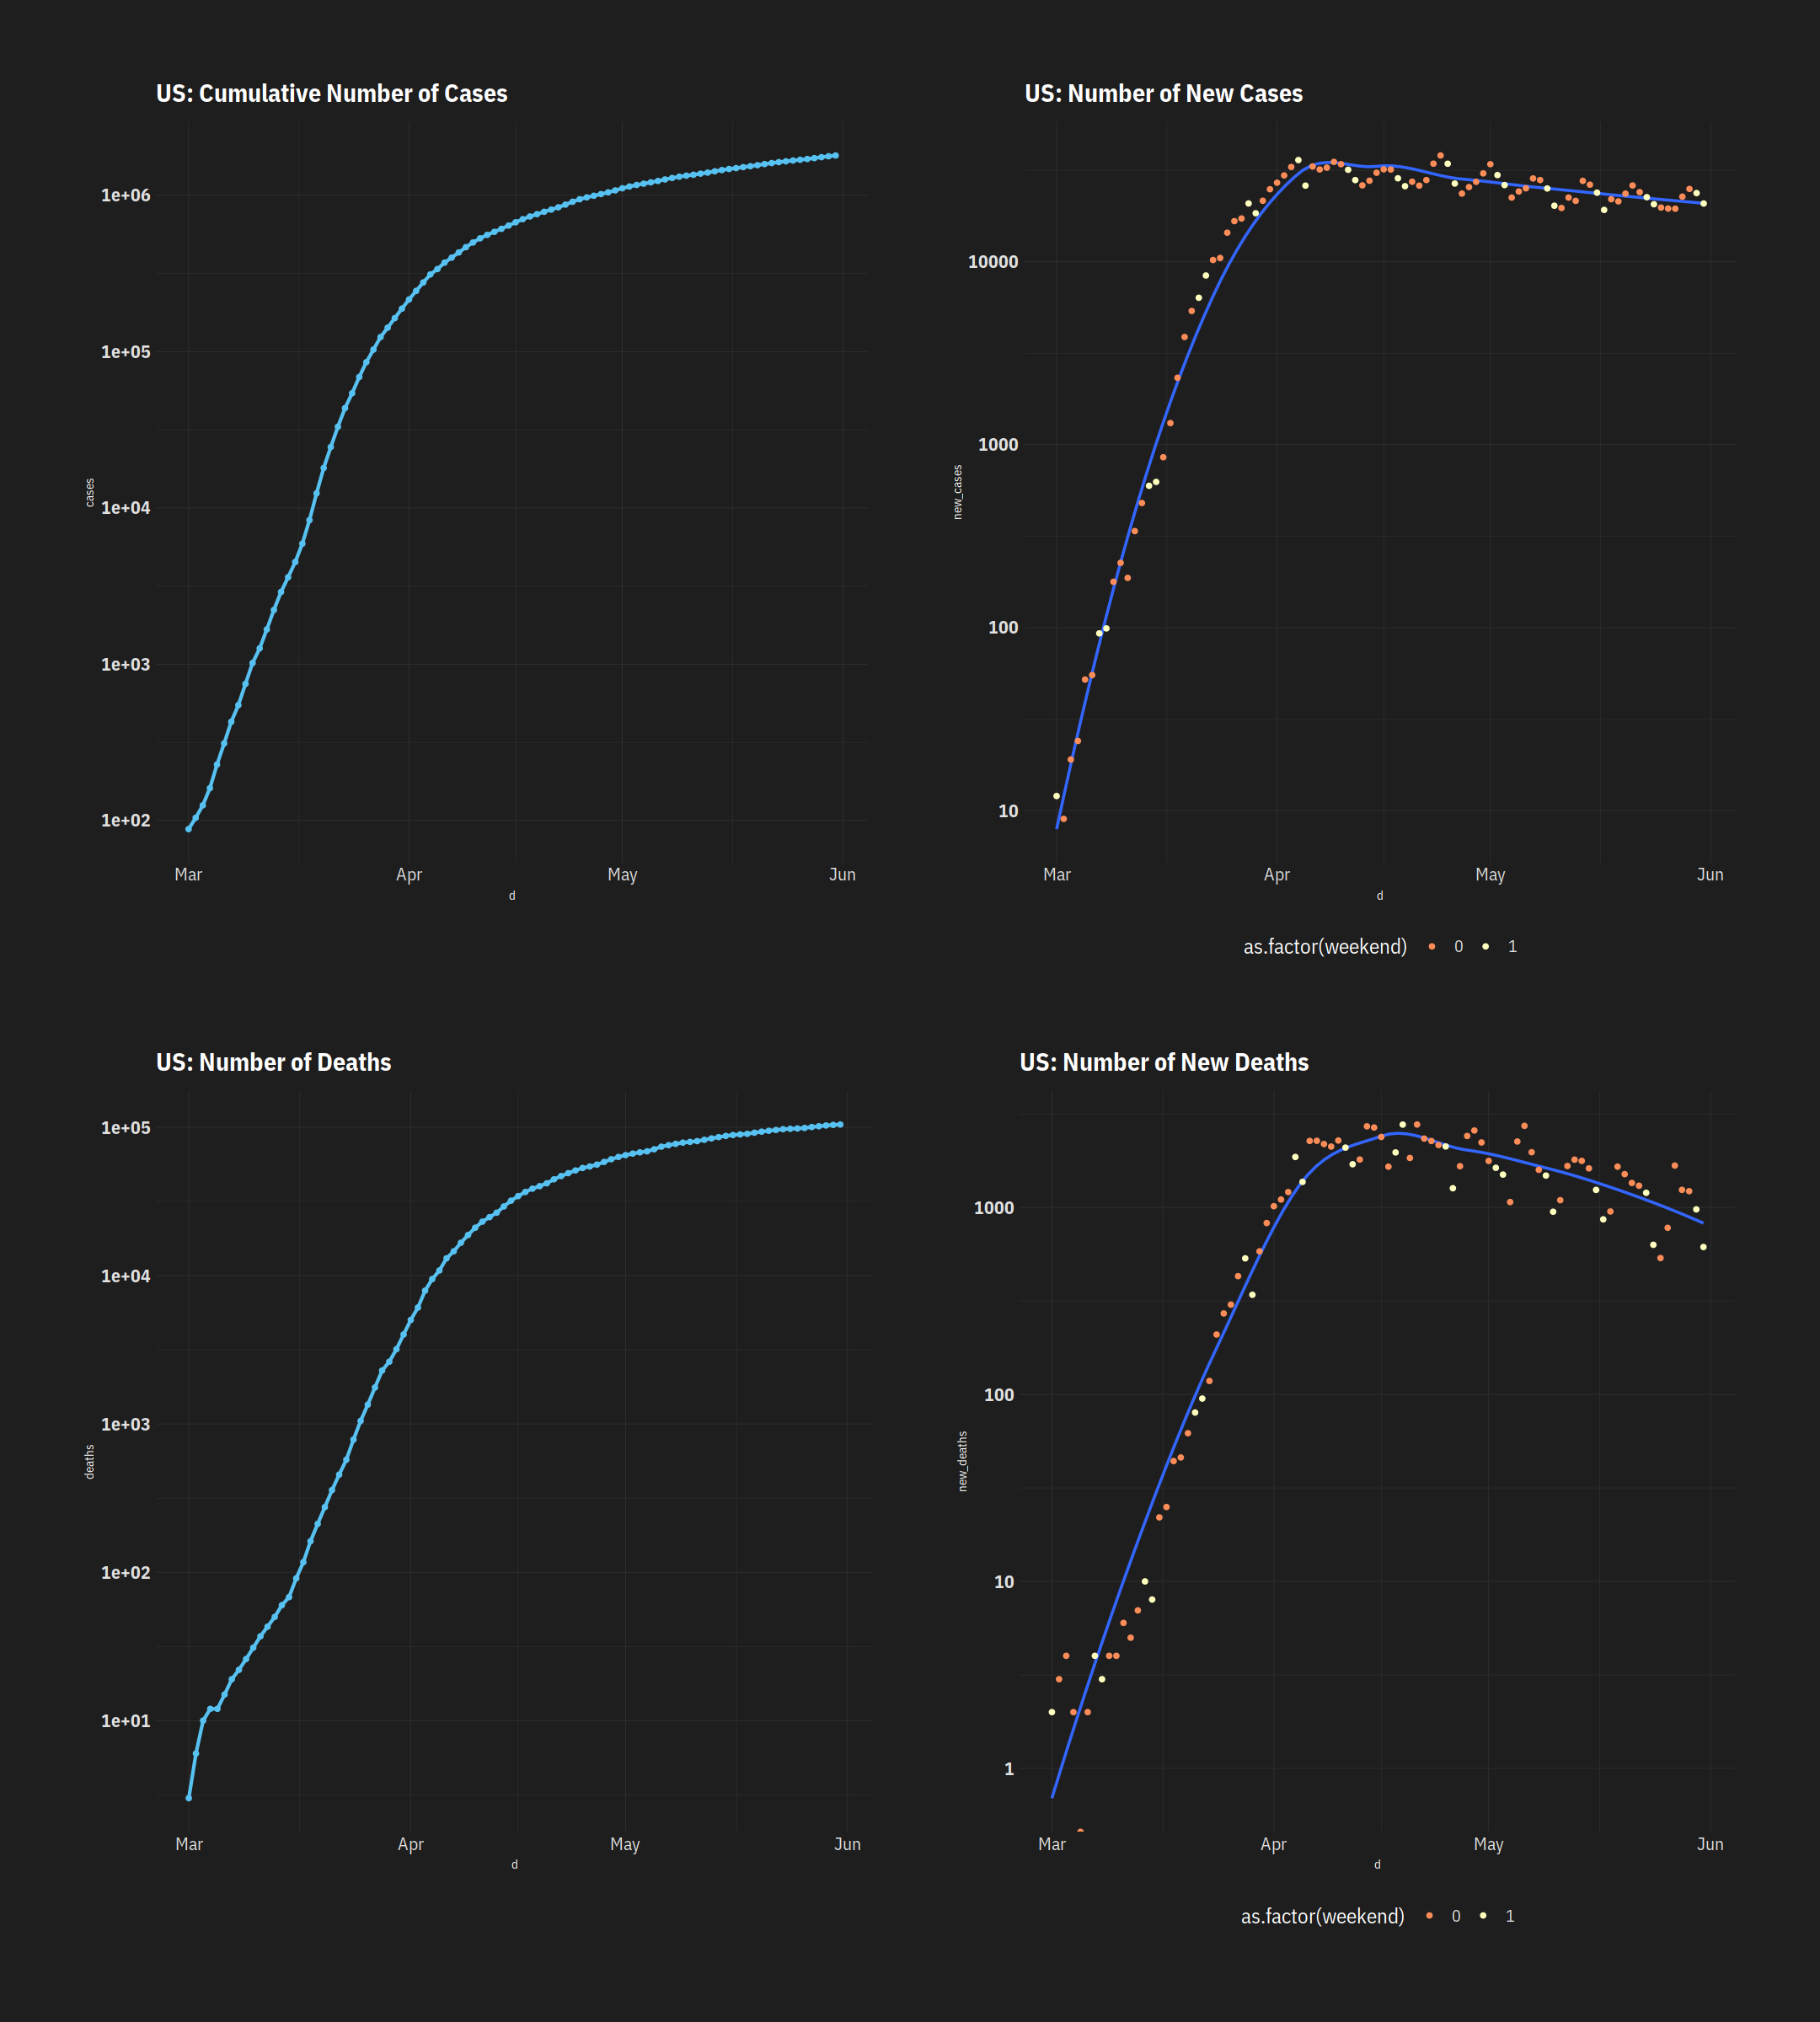

In [8]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(npan, aes(x = d, y = cases)) +
  geom_line(size = 1.2) + geom_point()+ 
  scale_y_log10() +
  ggtitle("US: Cumulative Number of Cases")

p11 = ggplot(npan, aes(x = d, y = new_cases)) +
#   geom_line(aes(y = rm_new_cases)) +
    geom_smooth(se = F) +
    geom_point(aes( colour = as.factor(weekend))) +
    scale_y_log10() +
    scale_colour_brewer(palette = "Spectral") + 
    ggtitle("US: Number of New Cases")

p2 = ggplot(npan, aes(x = d, y = deaths)) +
  geom_line(size = 1.2) + geom_point() +
  scale_y_log10() +
  ggtitle("US: Number of Deaths")

p22 = ggplot(npan, aes(x = d, y = new_deaths)) +
#   geom_line(aes(y = rm_new_deaths)) +
    geom_smooth(se = F) +
    geom_point(aes(colour = as.factor(weekend))) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") + 
    ggtitle("US: Number of New Deaths")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

In [9]:
options(repr.plot.width = 10, repr.plot.height=8)
nat_cfr = ggplot(npan[d>= "2020-03-15"], aes(x = d, y = cfr)) +
  geom_line(aes(y = rm_cfr)) + geom_point()+ 
  ggtitle("US: CFR")

## State Panel 

In [10]:
stpan = df[, lapply(.SD, sum, na.rm = T), by = .(state, d), .SDcols = rawvars]
(t10 = stpan[d == max(d)][order(-cases)][1:10])
stpan[, cfr := deaths/cases]
stpan = rollmeaneR(stpan, c(rawvars, 'cfr'), grouping = "state")

state,d,cases,deaths,new_cases,new_deaths
<chr>,<date>,<int>,<int>,<dbl>,<dbl>
New York,2020-05-31,375575,29699,1104,87
New Jersey,2020-05-31,160445,11698,939,64
Illinois,2020-05-31,120588,5426,1302,58
California,2020-05-31,113114,4242,3014,28
Massachusetts,2020-05-31,96965,6846,703,78
Pennsylvania,2020-05-31,76218,5555,429,18
Texas,2020-05-31,64974,1683,1579,7
Michigan,2020-05-31,57355,5491,507,28
Florida,2020-05-31,56155,2450,742,4


Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 6 rows containing missing values (geom_smooth).”


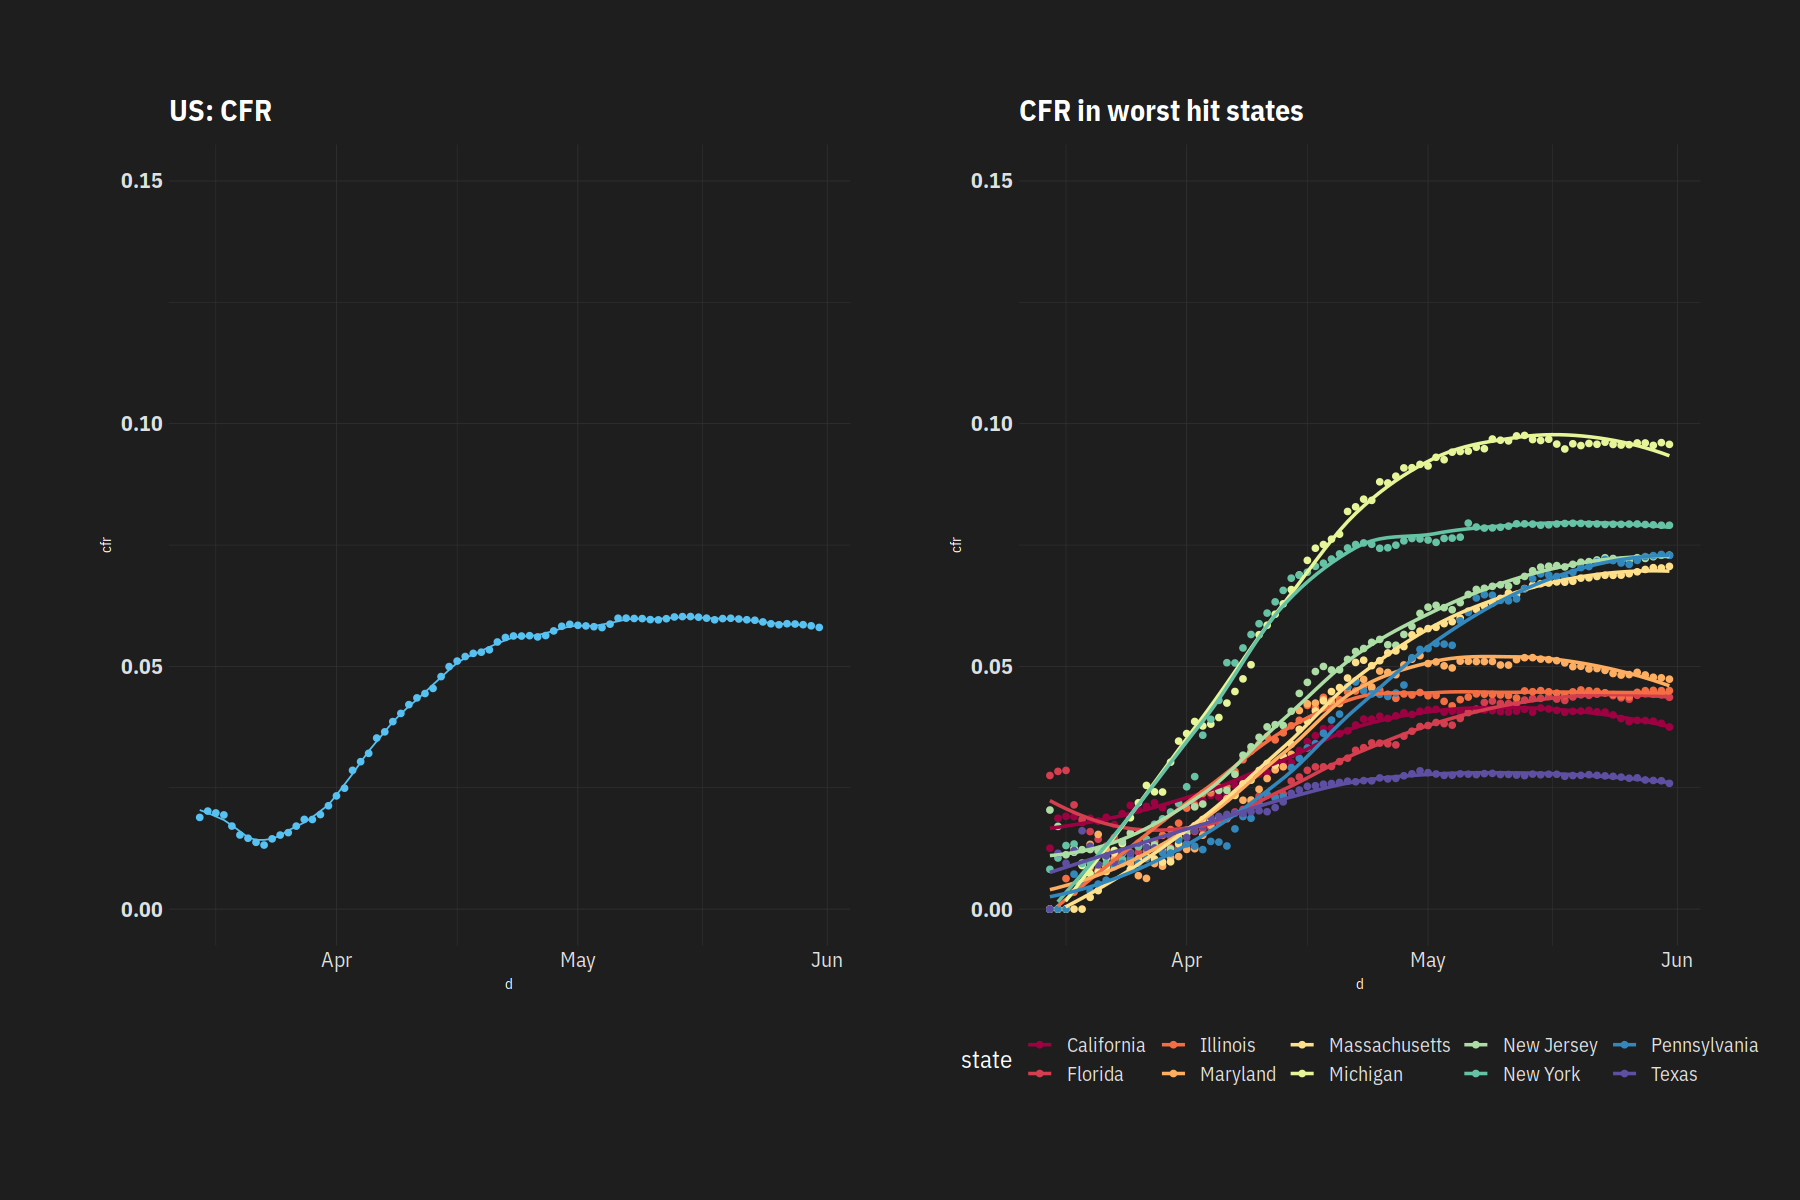

In [11]:
options(repr.plot.width = 15, repr.plot.height=10)
state_cfr = ggplot(stpan[state %in% t10$state & d >= "2020-03-15"], aes(x = d, y = cfr, group = state, colour = state)) +
    geom_point() + geom_smooth(se = F) +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("CFR in worst hit states")
nat_cfr + ylim(c(0, 0.15)) | state_cfr + ylim(c(0, 0.15))

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


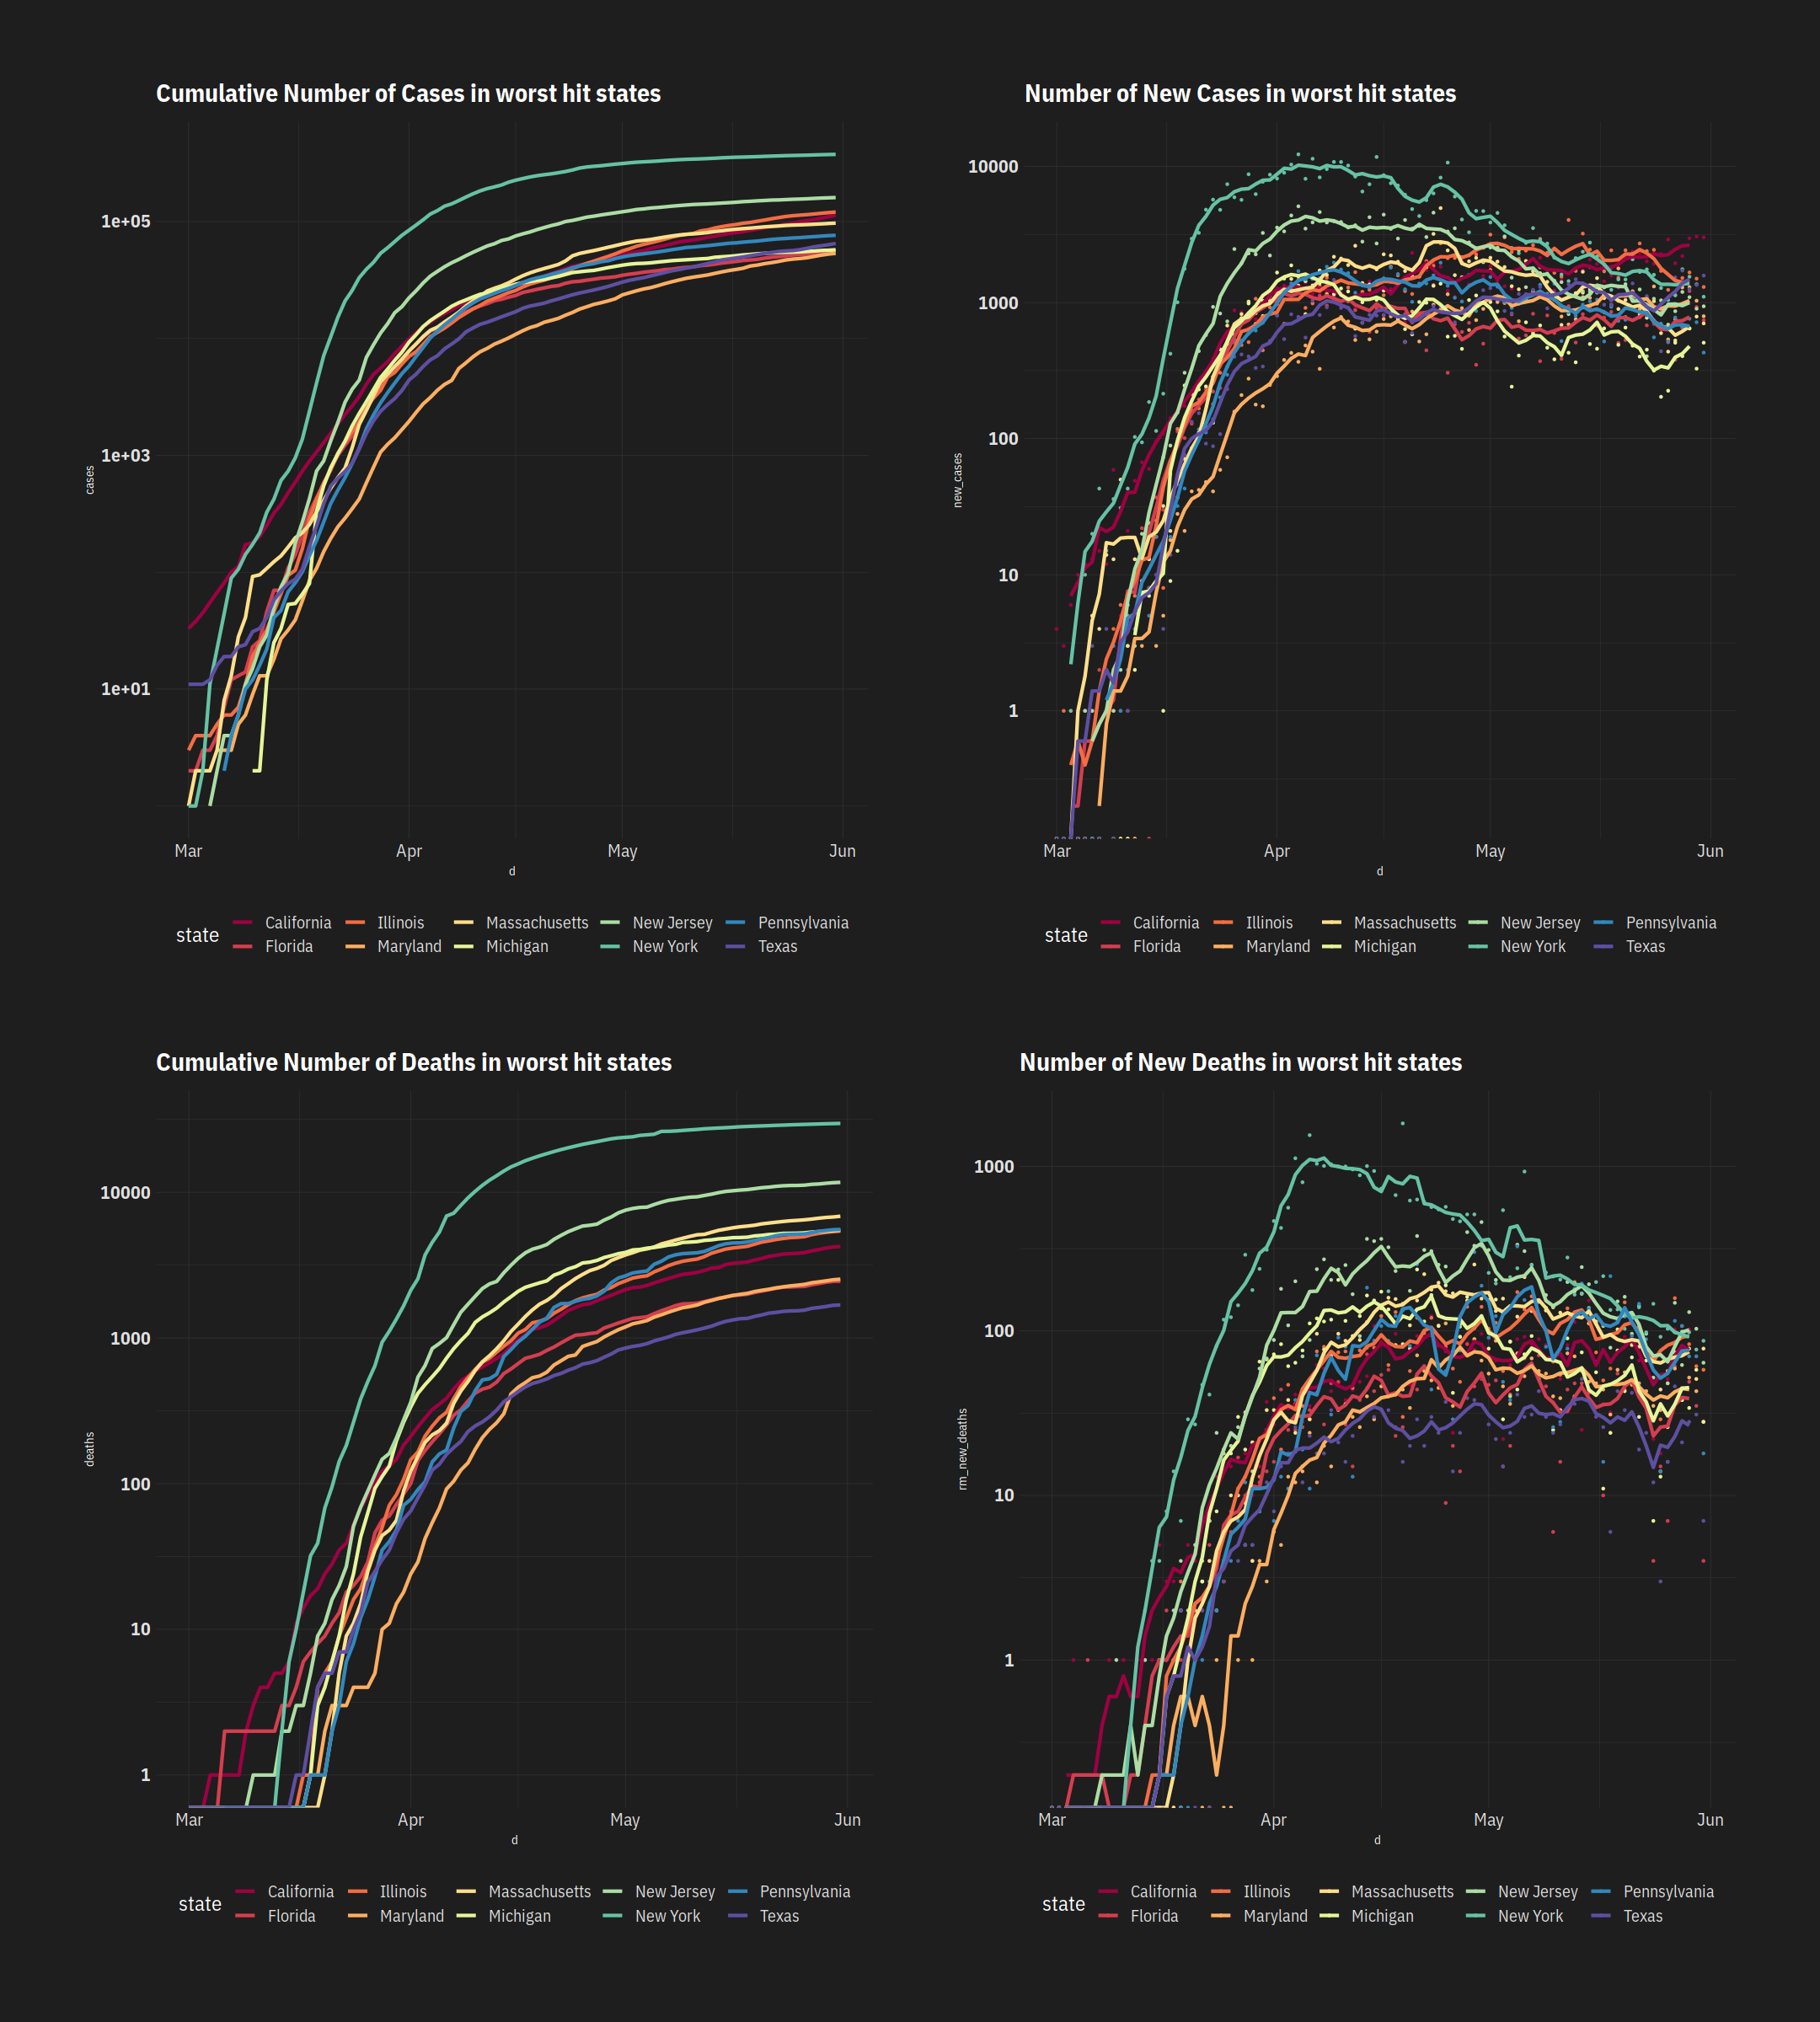

In [12]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(stpan[state %in% t10$state], aes(x = d, y = cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Cases in worst hit states")

p11 = ggplot(stpan[state %in% t10$state], aes(x = d, group = state, colour = state)) +
  geom_point(aes(y = new_cases), size = 0.6) +
  geom_line(aes(y = rm_new_cases), size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Cases in worst hit states")

p2 = ggplot(stpan[state %in% t10$state], aes(x = d, y = deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Deaths in worst hit states")

p22 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm_new_deaths, group = state, colour = state)) +
  geom_point(aes(y = new_deaths), size = 0.6) +
  geom_line(aes(y = rm_new_deaths), size = 1.2) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Deaths in worst hit states")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


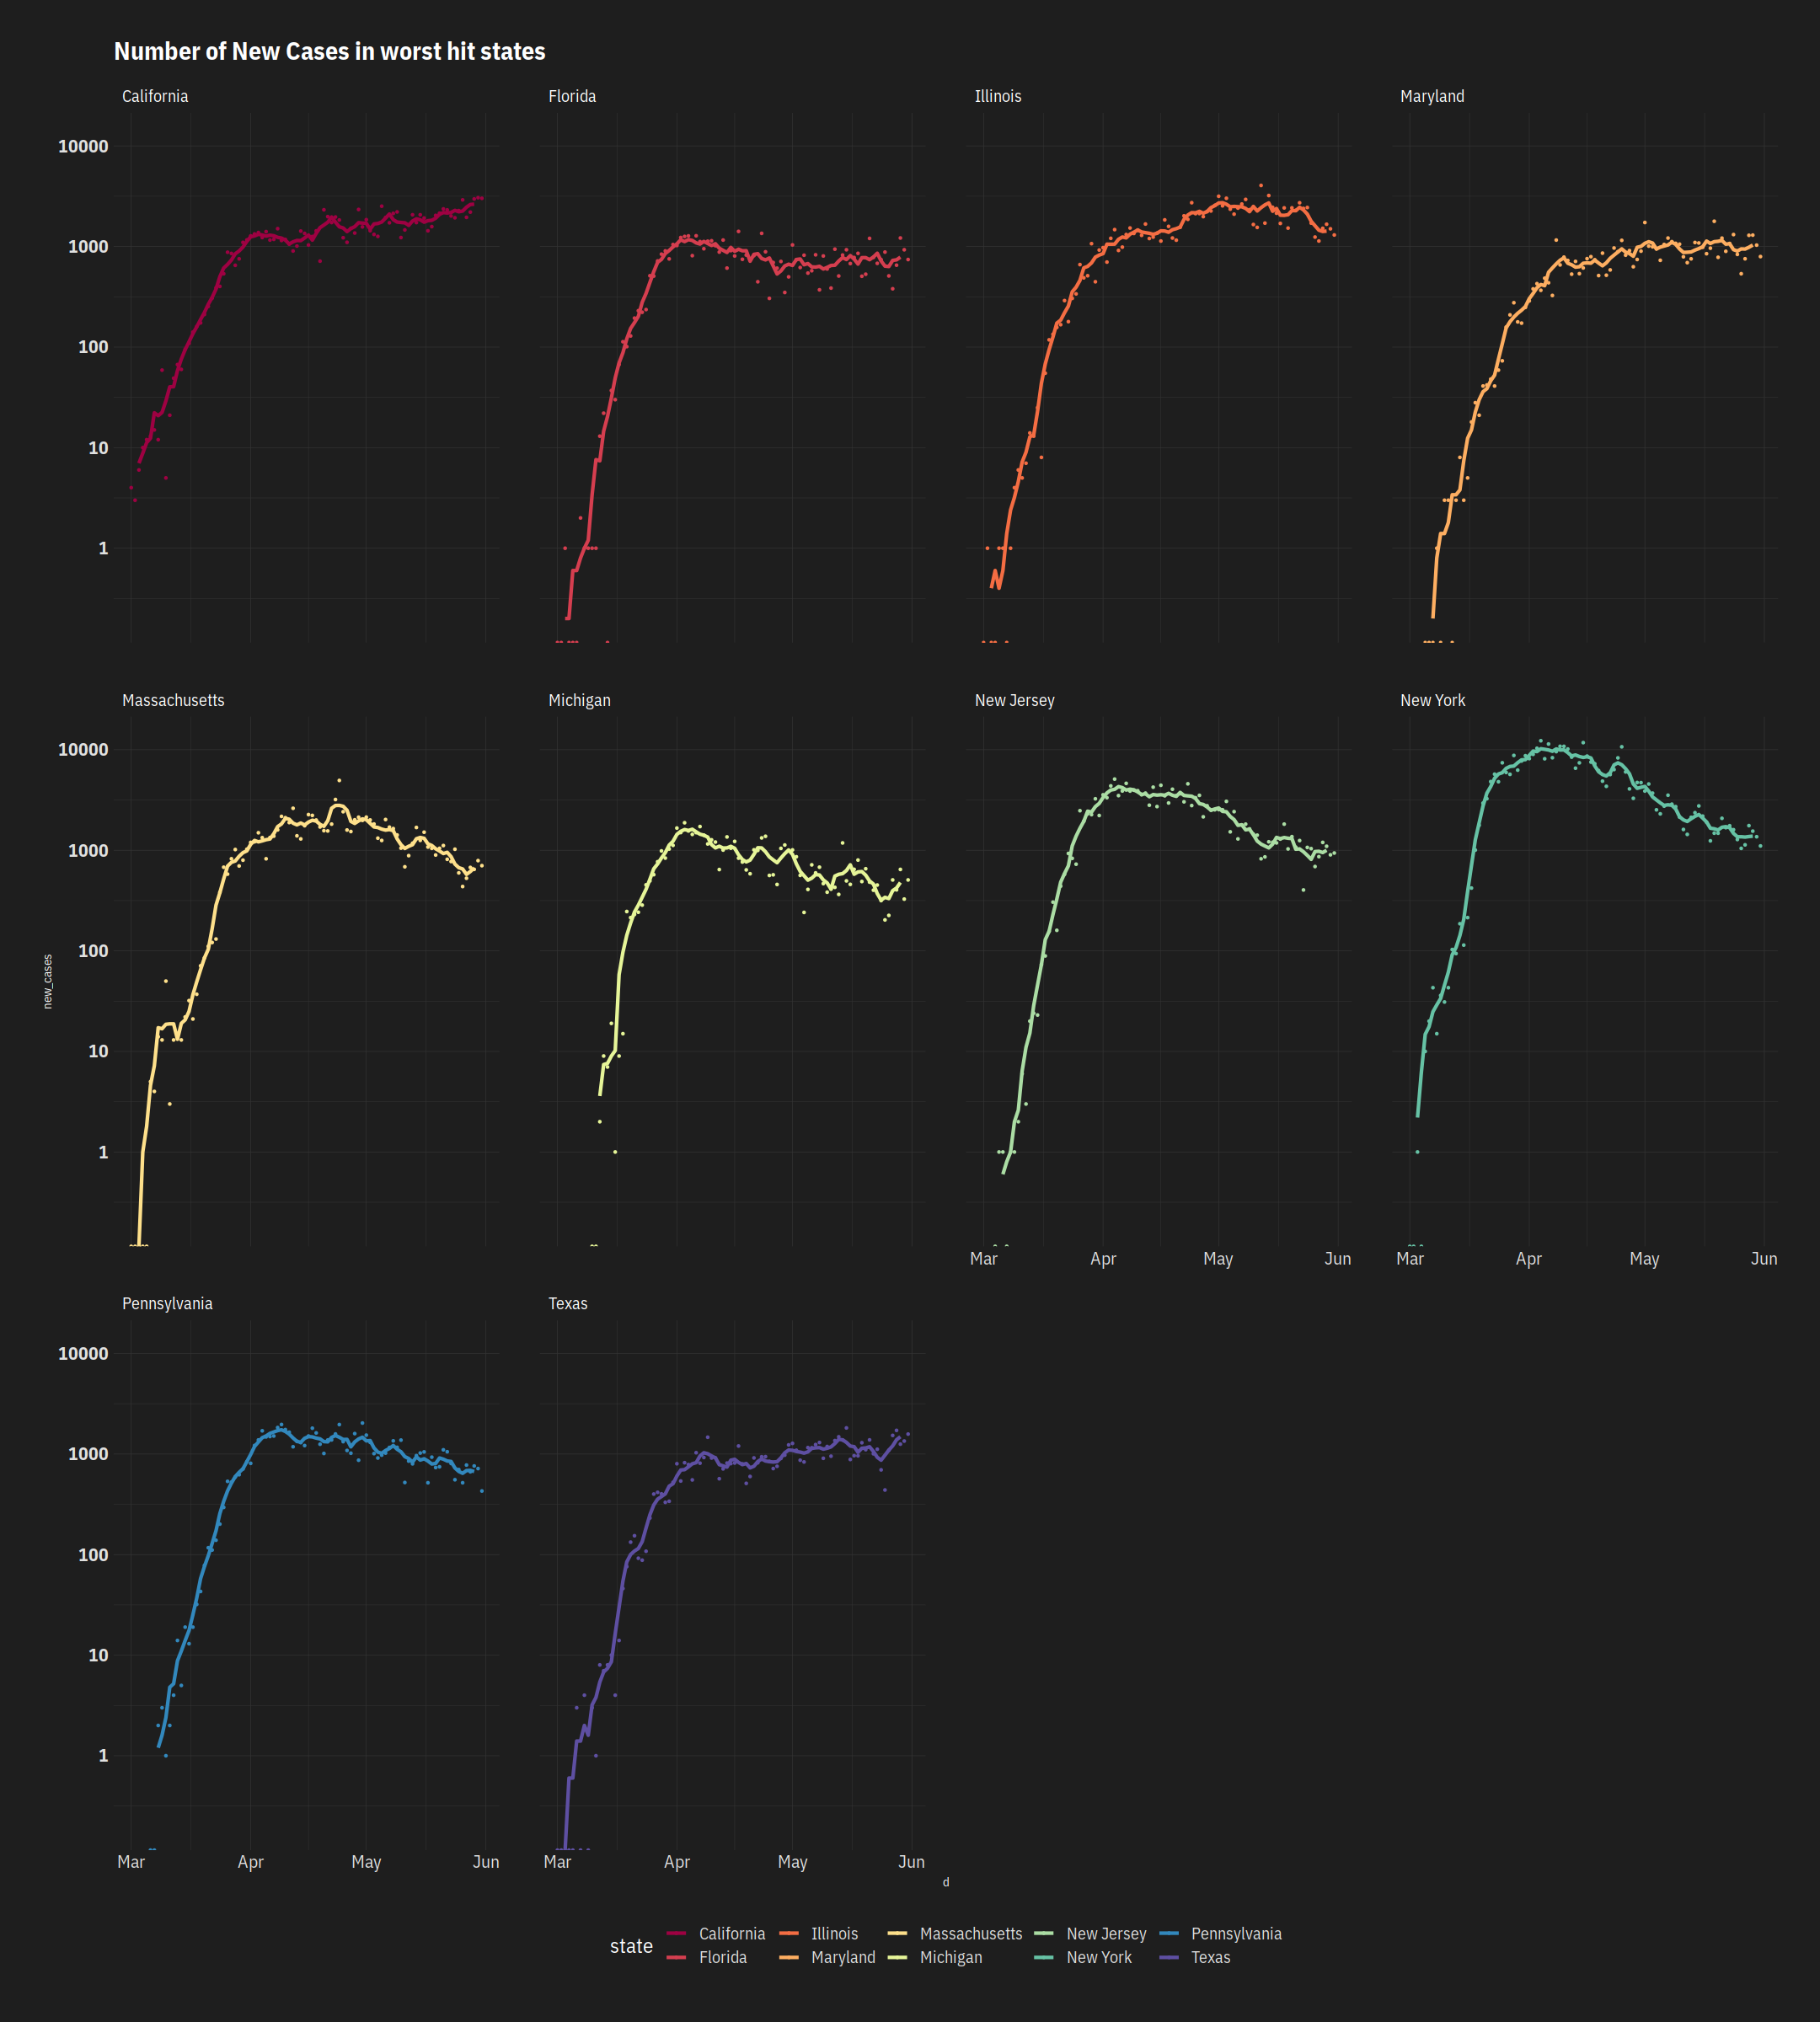

In [13]:
p11 + facet_wrap(~ state) 

## CA: Subregions

In [14]:
bay_counties = c(
  "San Francisco", "San Mateo", "Santa Clara",
  "Alameda", "Contra Costa", "Marin"
)

socal = c("Los Angeles", "Orange", "Ventura", "San Bernadino", "Riverside",
          "Imperial", "Kern", "San Diego", "Santa Barbara", "San Luis Obispo")

ca_all = df[state == "California"]
ca_all[, metro := case_when(
    county %in% bay_counties ~ "Bay",
    county %in% socal        ~ "SoCal",
    TRUE                     ~ "Elsewhere")]
vars = c("cases", "deaths", "new_cases", "new_deaths")
ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(metro, d), .SDcols = vars]

In [15]:
ca_div = rollmeaneR(ca_div, smoothvars = vars, grouping = 'metro')

In [16]:
kvs = c("cases", "deaths", "new_cases", "new_deaths", 'd')
cur = ca_div[order(-d), .SD[1], by = metro, .SDcols = kvs]
cur[, cfr := (deaths / cases)][]
cur[, lapply(.SD, sum, na.rm = T), .SDcols = vars]

metro,cases,deaths,new_cases,new_deaths,d,cfr
<chr>,<int>,<int>,<dbl>,<dbl>,<date>,<dbl>
Bay,12810,422,238,1,2020-05-31,0.03294
Elsewhere,16521,550,562,2,2020-05-31,0.03329
SoCal,83783,3270,2214,25,2020-05-31,0.03903


cases,deaths,new_cases,new_deaths
<int>,<int>,<dbl>,<dbl>
113114,4242,3014,28


Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


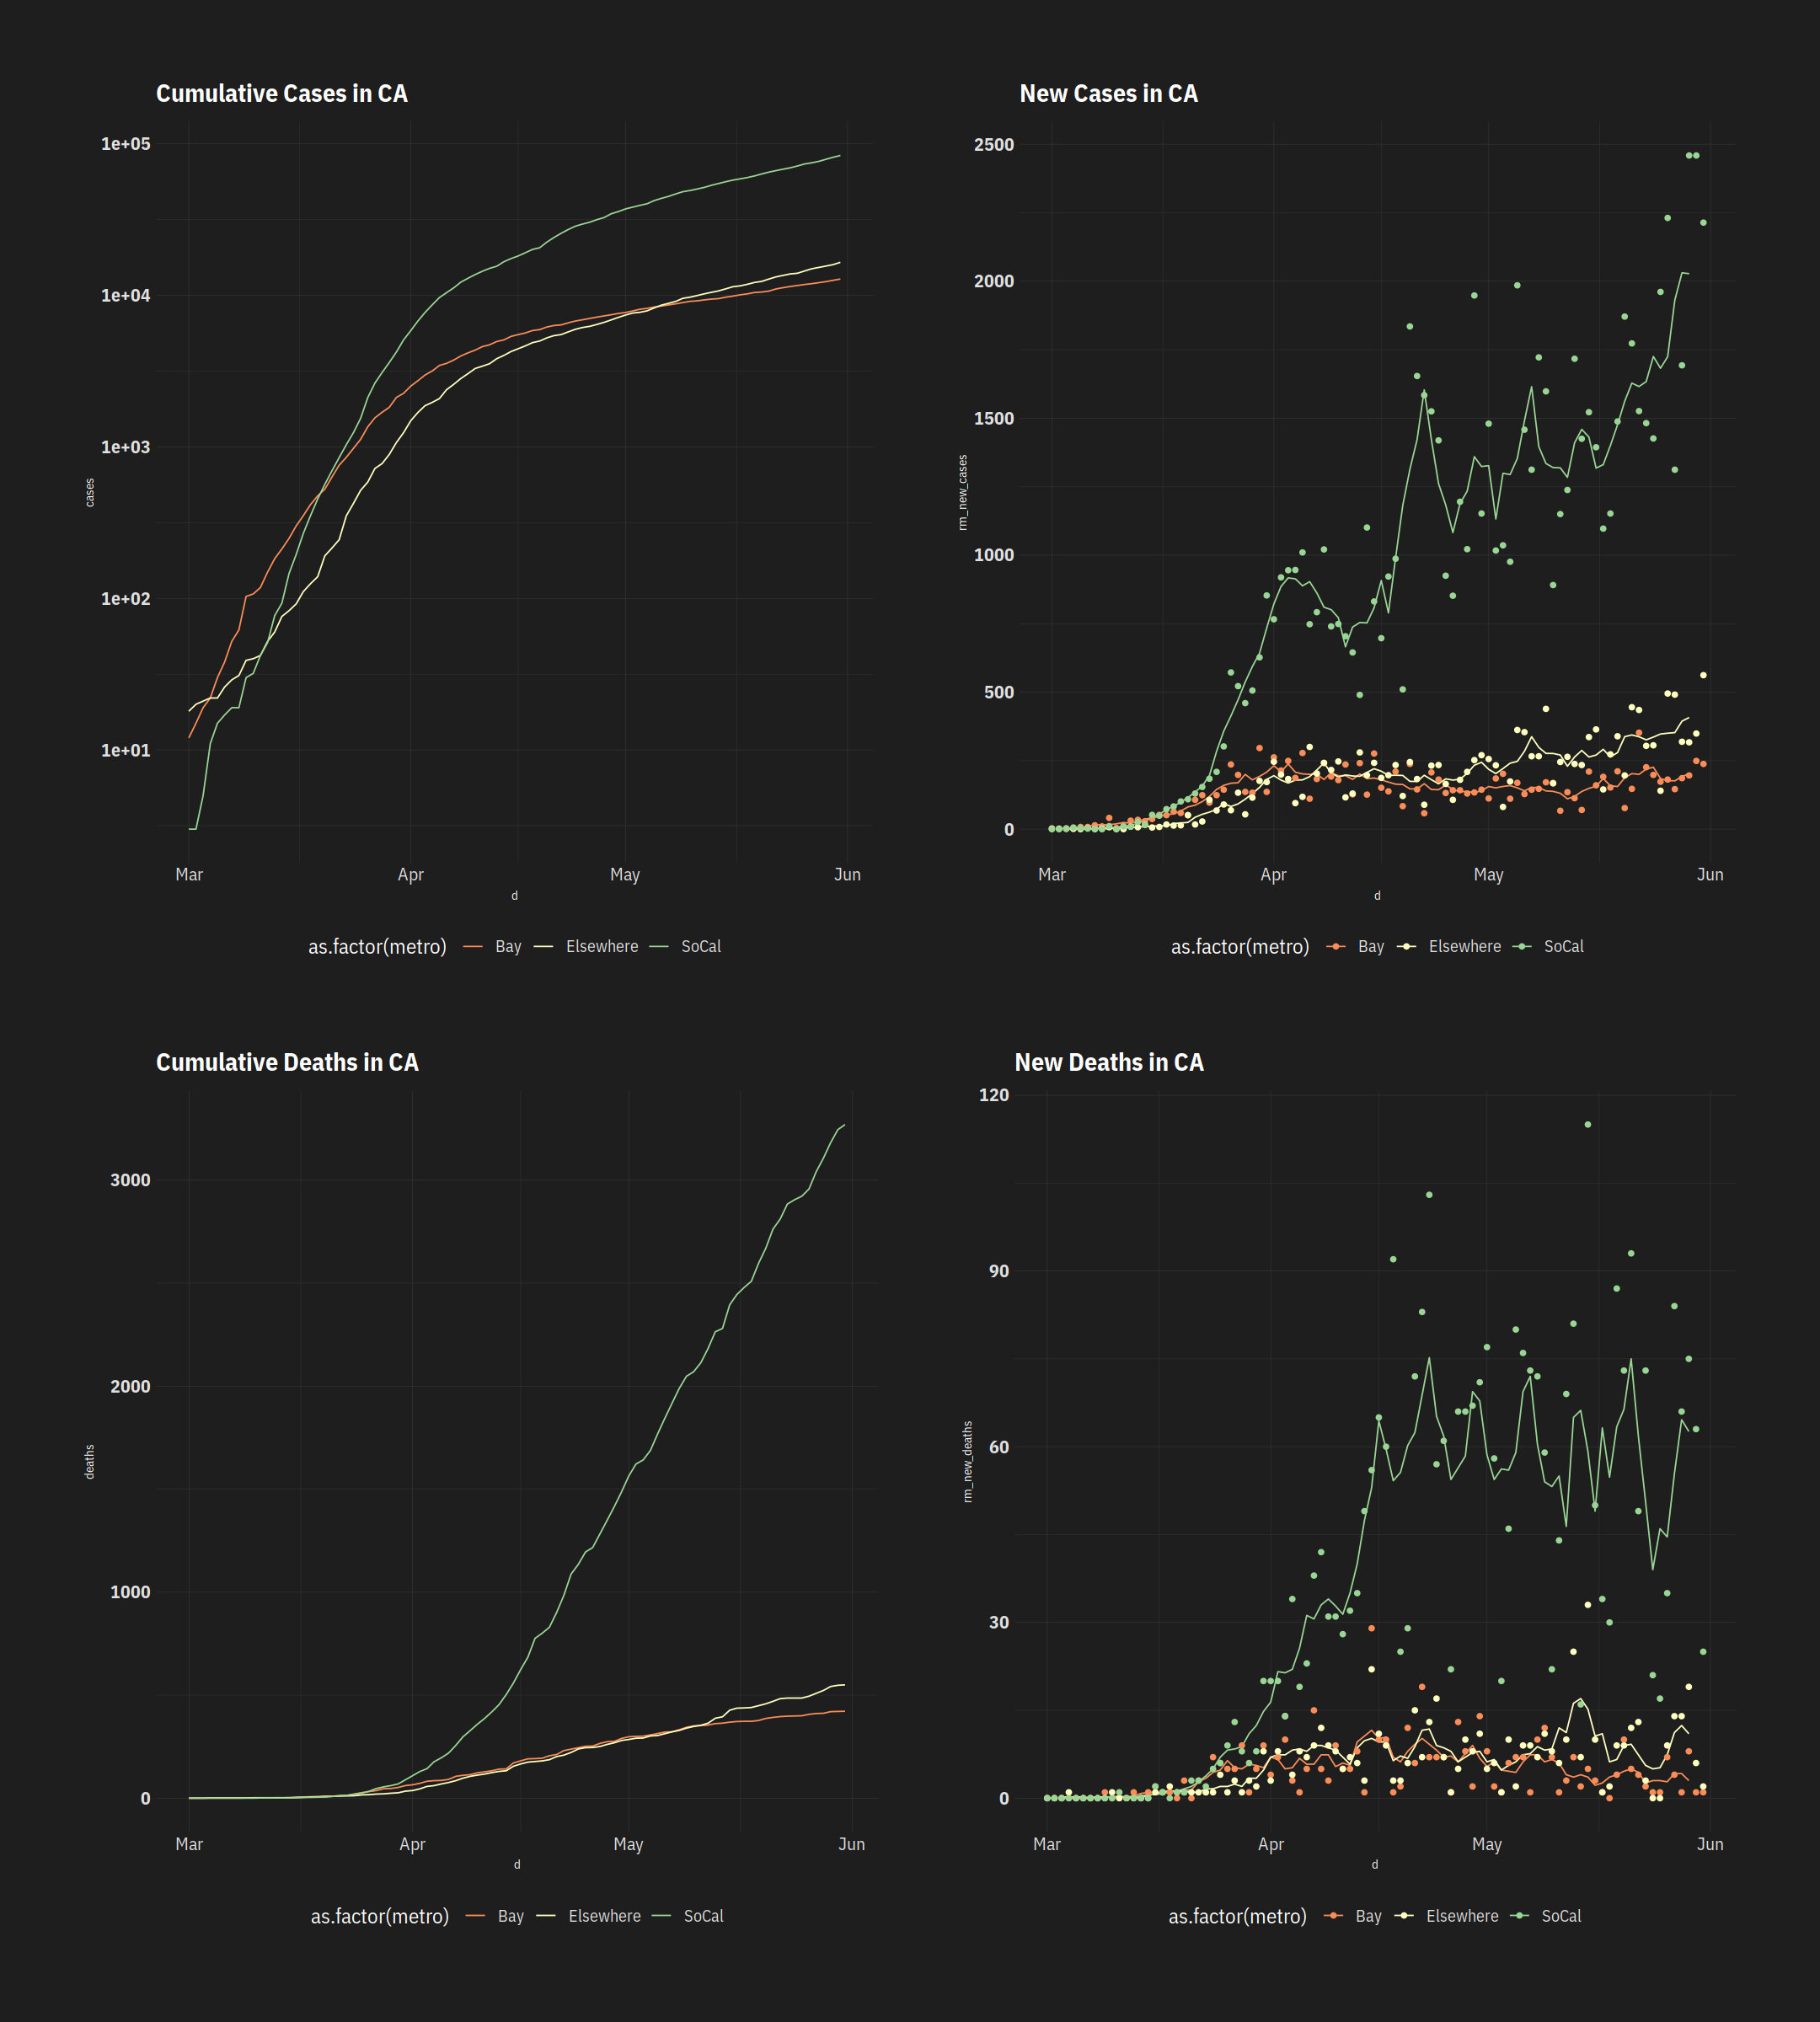

In [17]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(metro), colour = as.factor(metro))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d,  group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_cases)) +
  geom_point(aes(y = new_cases)) +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Cases in CA")

p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line() +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Deaths in CA")

p4 = ggplot(ca_div, aes(x = d, y = rm_new_deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_deaths)) +
  geom_point(aes(y = new_deaths)) +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2) / (p3 | p4)

## Counties within the Bay Area

In [18]:
bayrea_mar = rollmeaneR(df[county %in% bay_counties & state == "California" & d>= "2020-03-01"])
bayrea_mar[, cfr := deaths/cases]
bayrea_mar[d == max(d)]

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths
<chr>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-05-31,Alameda,California,6001,3411,103,2020-05-31,0.03020,101,0,NA,NA,NA,NA
2020-05-31,Contra Costa,California,6013,1450,37,2020-05-31,0.02552,24,0,NA,NA,NA,NA
2020-05-31,Marin,California,6041,483,14,2020-05-31,0.02899,17,0,NA,NA,NA,NA
2020-05-31,San Francisco,California,6075,2561,42,2020-05-31,0.01640,26,1,NA,NA,NA,NA
2020-05-31,San Mateo,California,6081,2129,84,2020-05-31,0.03946,25,0,NA,NA,NA,NA
2020-05-31,Santa Clara,California,6085,2776,142,2020-05-31,0.05115,45,0,NA,NA,NA,NA


### Cases

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


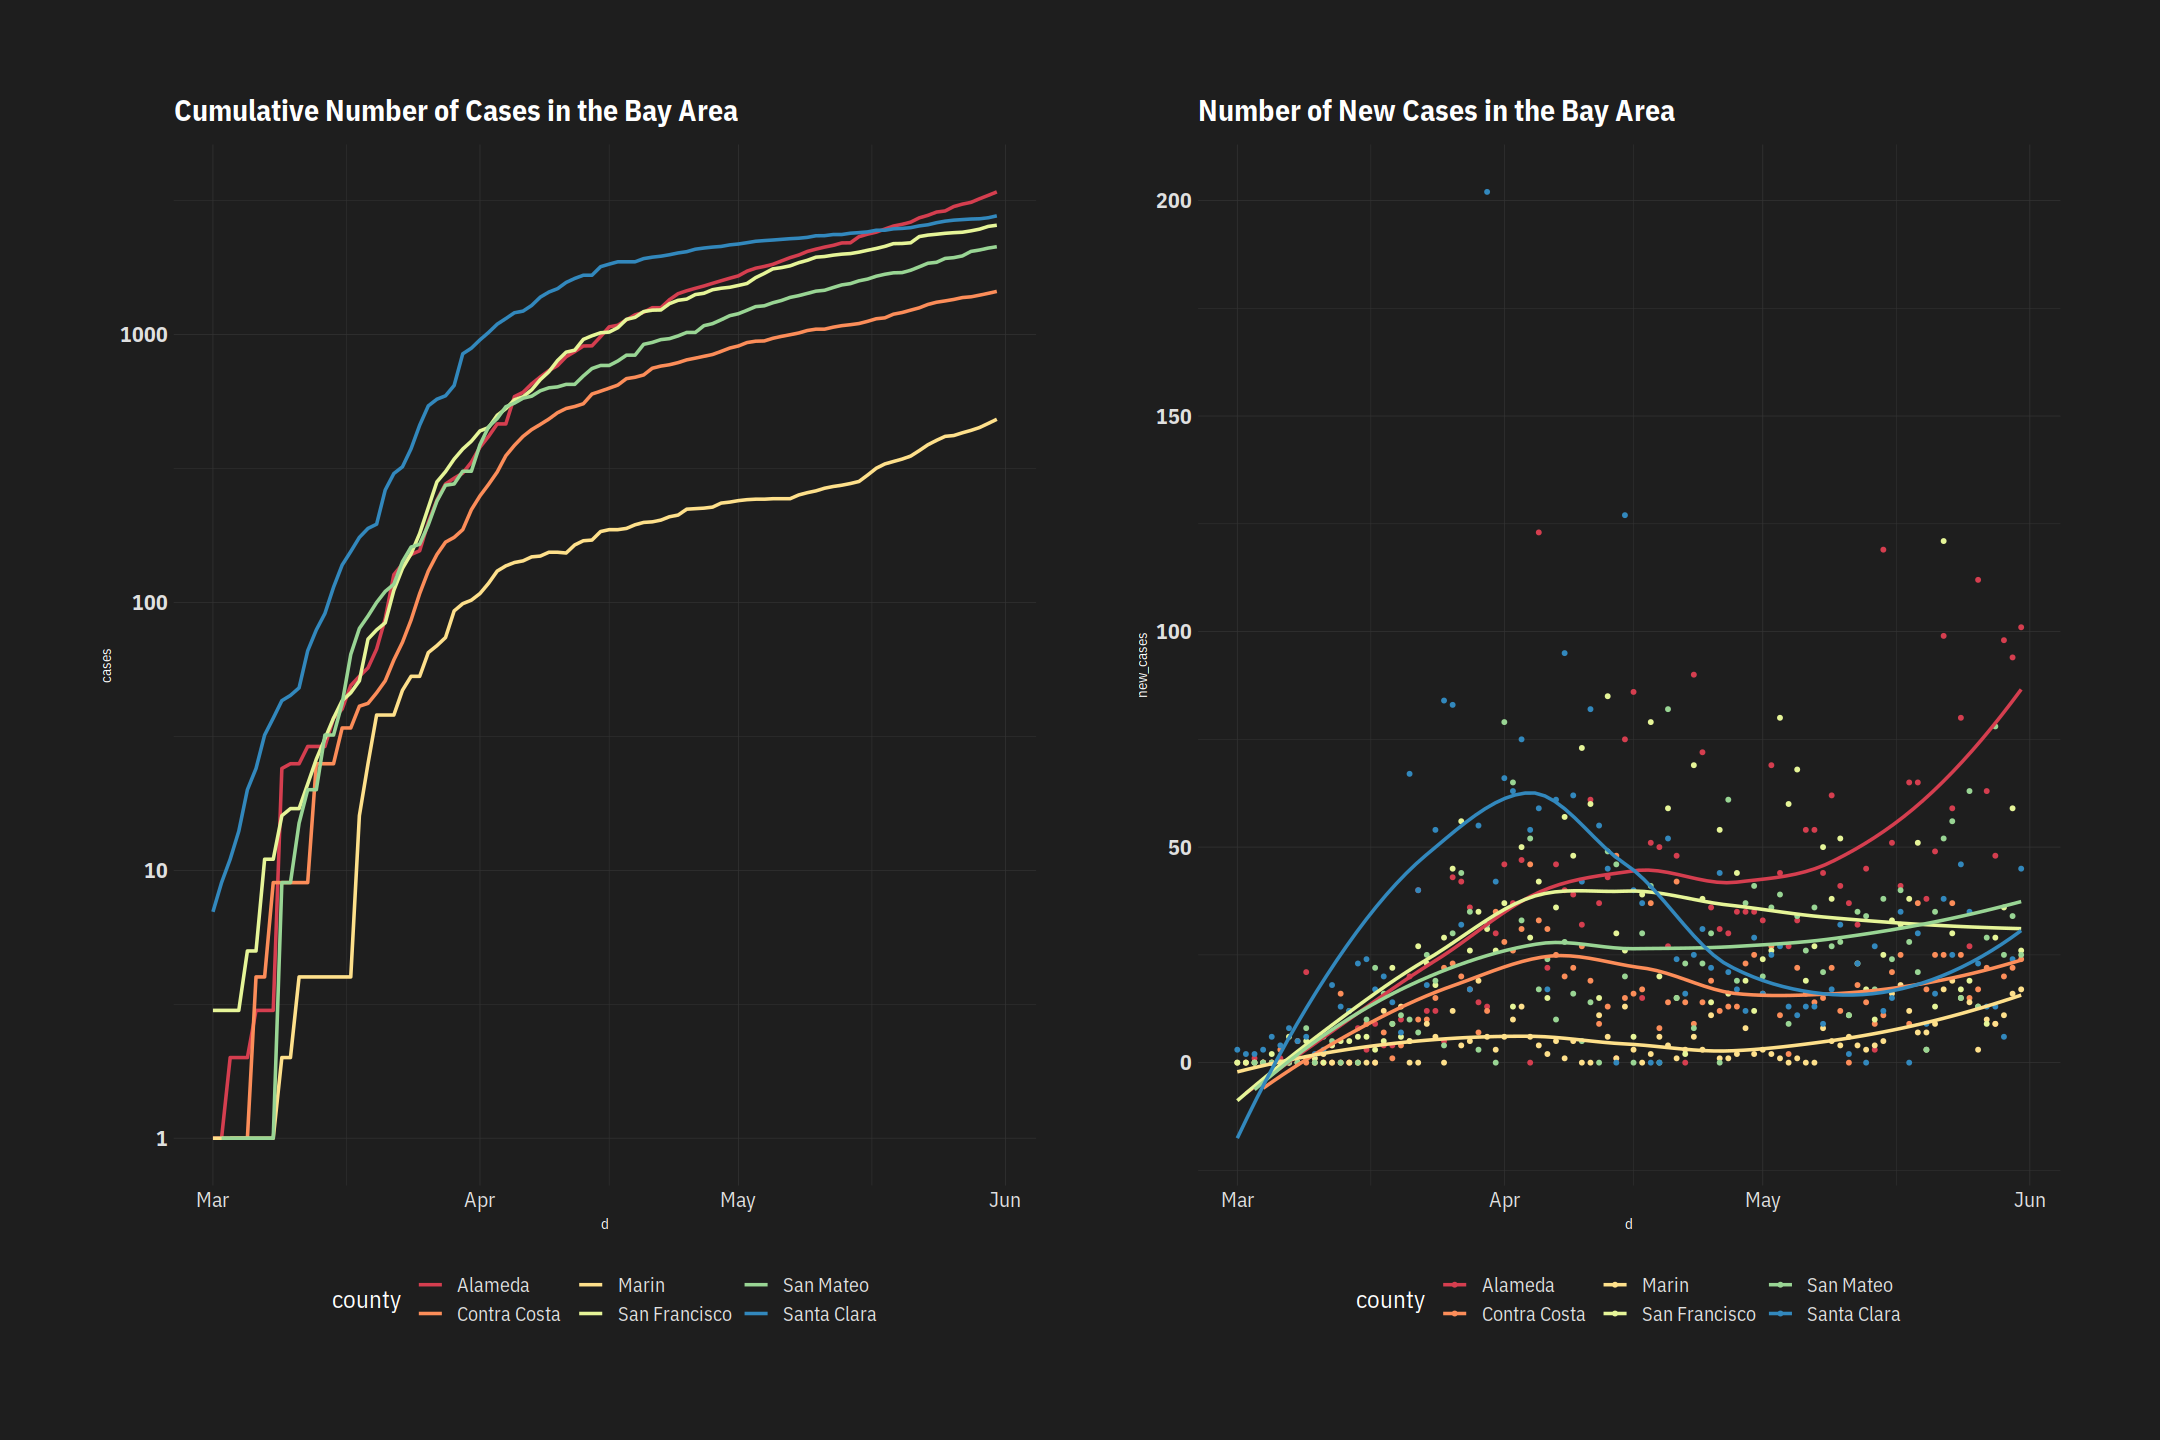

In [19]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = new_cases, group = county, colour = county)) +
  geom_point(size = 1) +
    geom_smooth(se = F) +
    scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Number of New Cases in the Bay Area")
options(repr.plot.width = 18, repr.plot.height=12)
(p1 | p2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


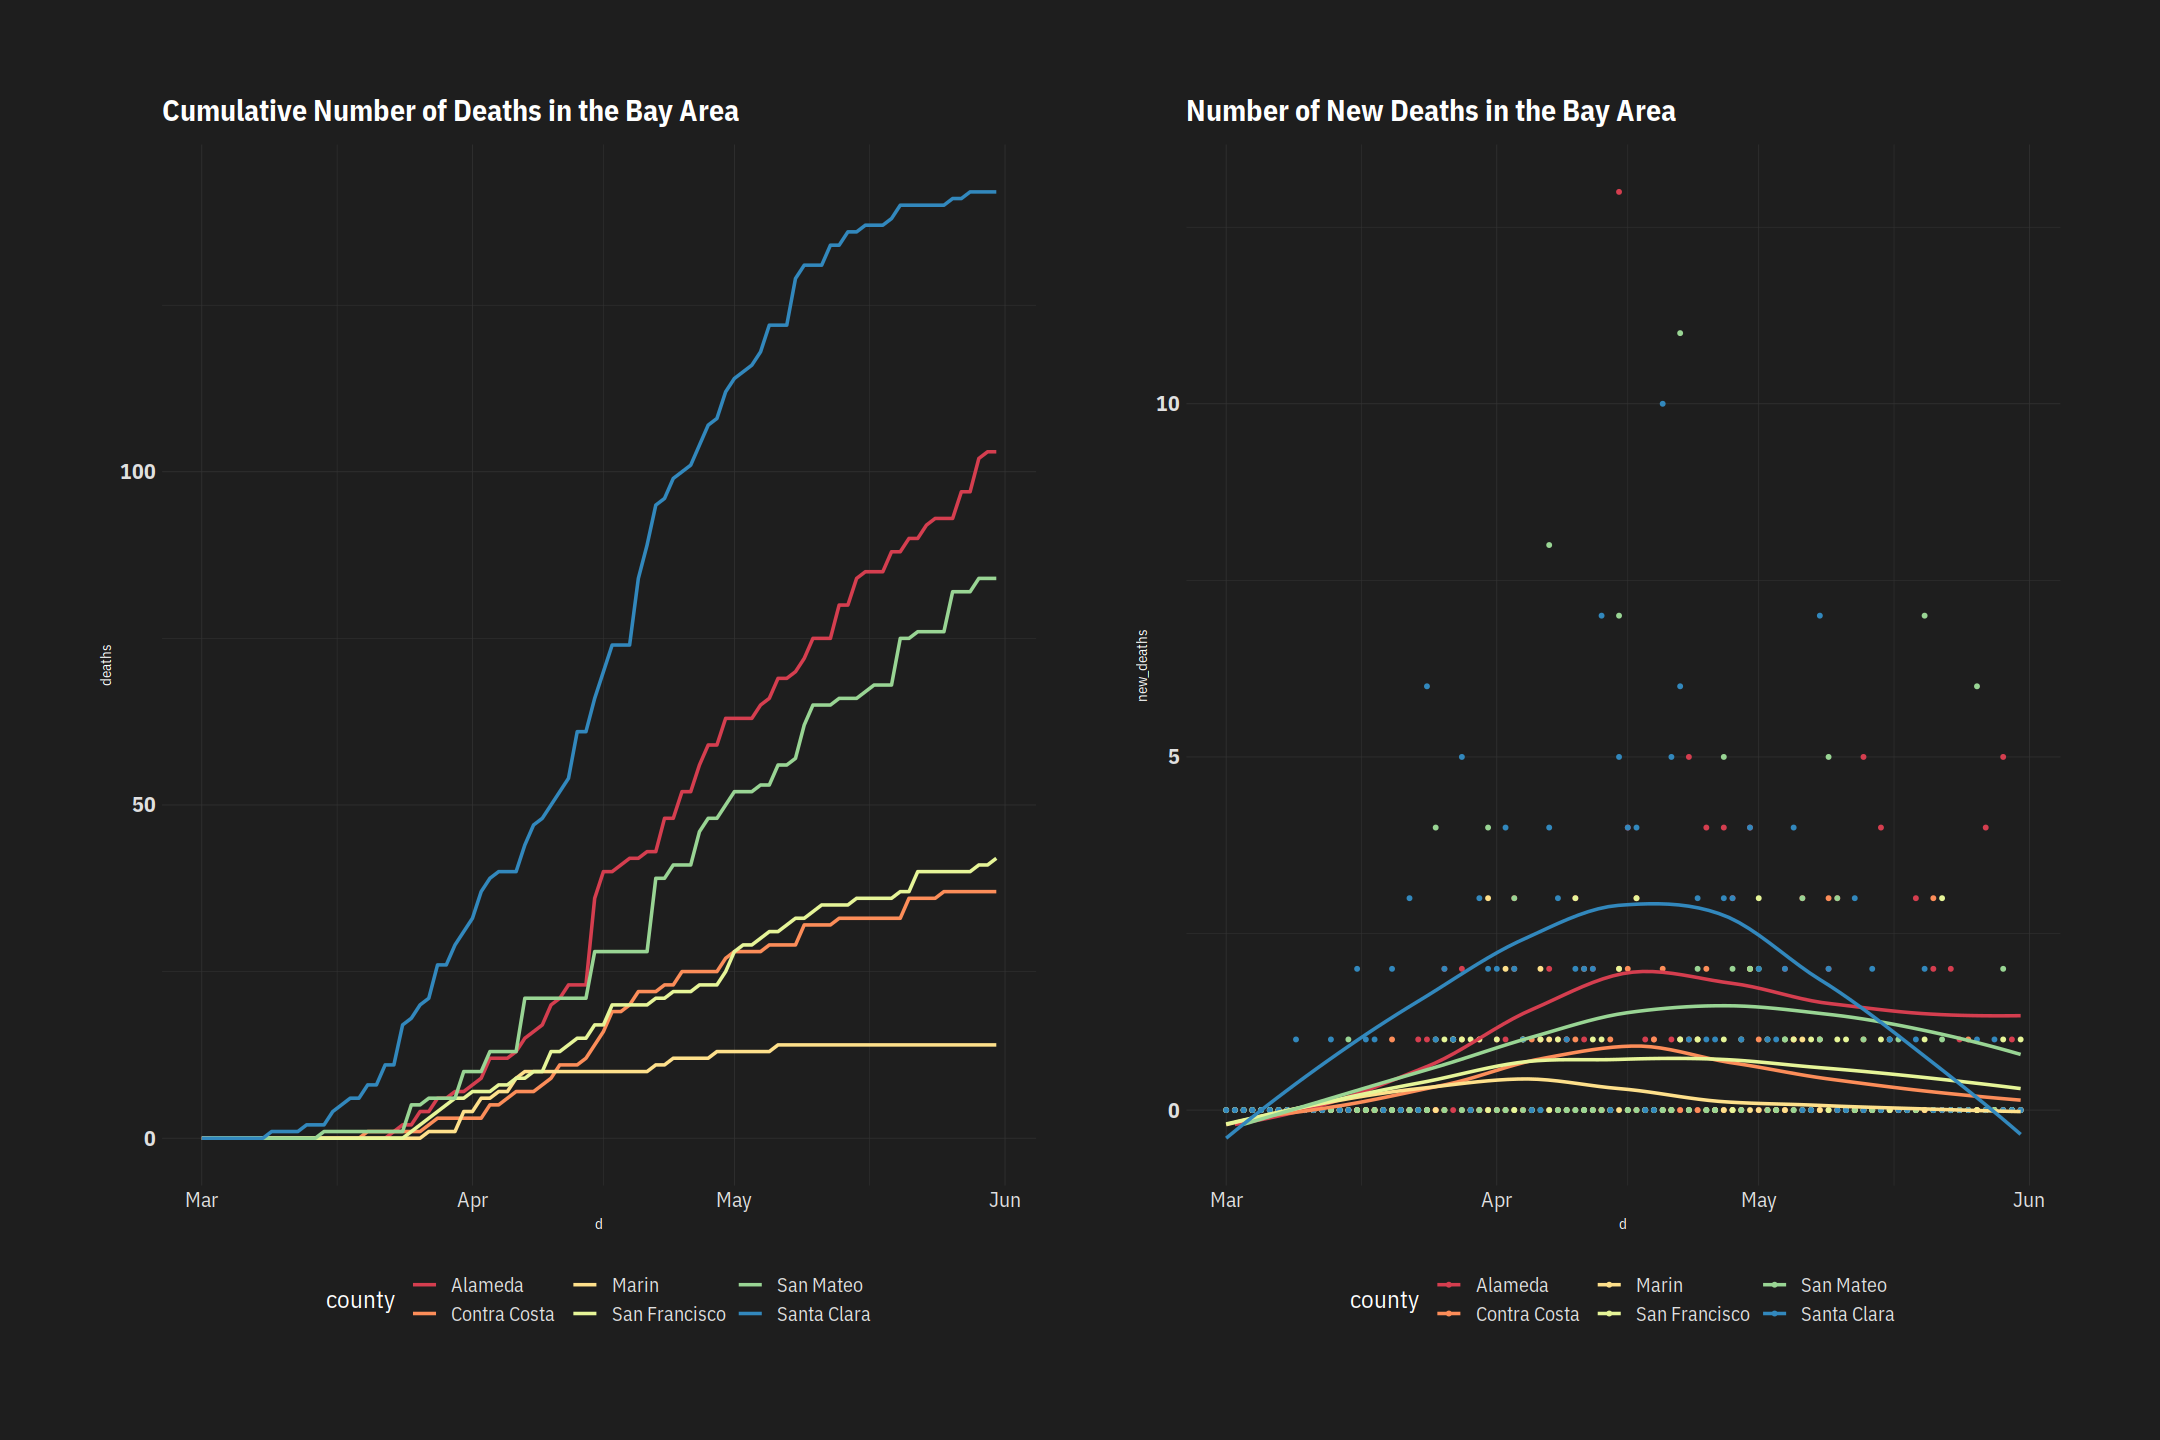

In [20]:
p1 = ggplot(bayrea_mar, aes(x = d, y = deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = new_deaths, group = county, colour = county)) +
  geom_point(aes(y = new_deaths), size = 1) +
#   geom_line(size = 1) +
  geom_smooth(se = F) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 | p2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



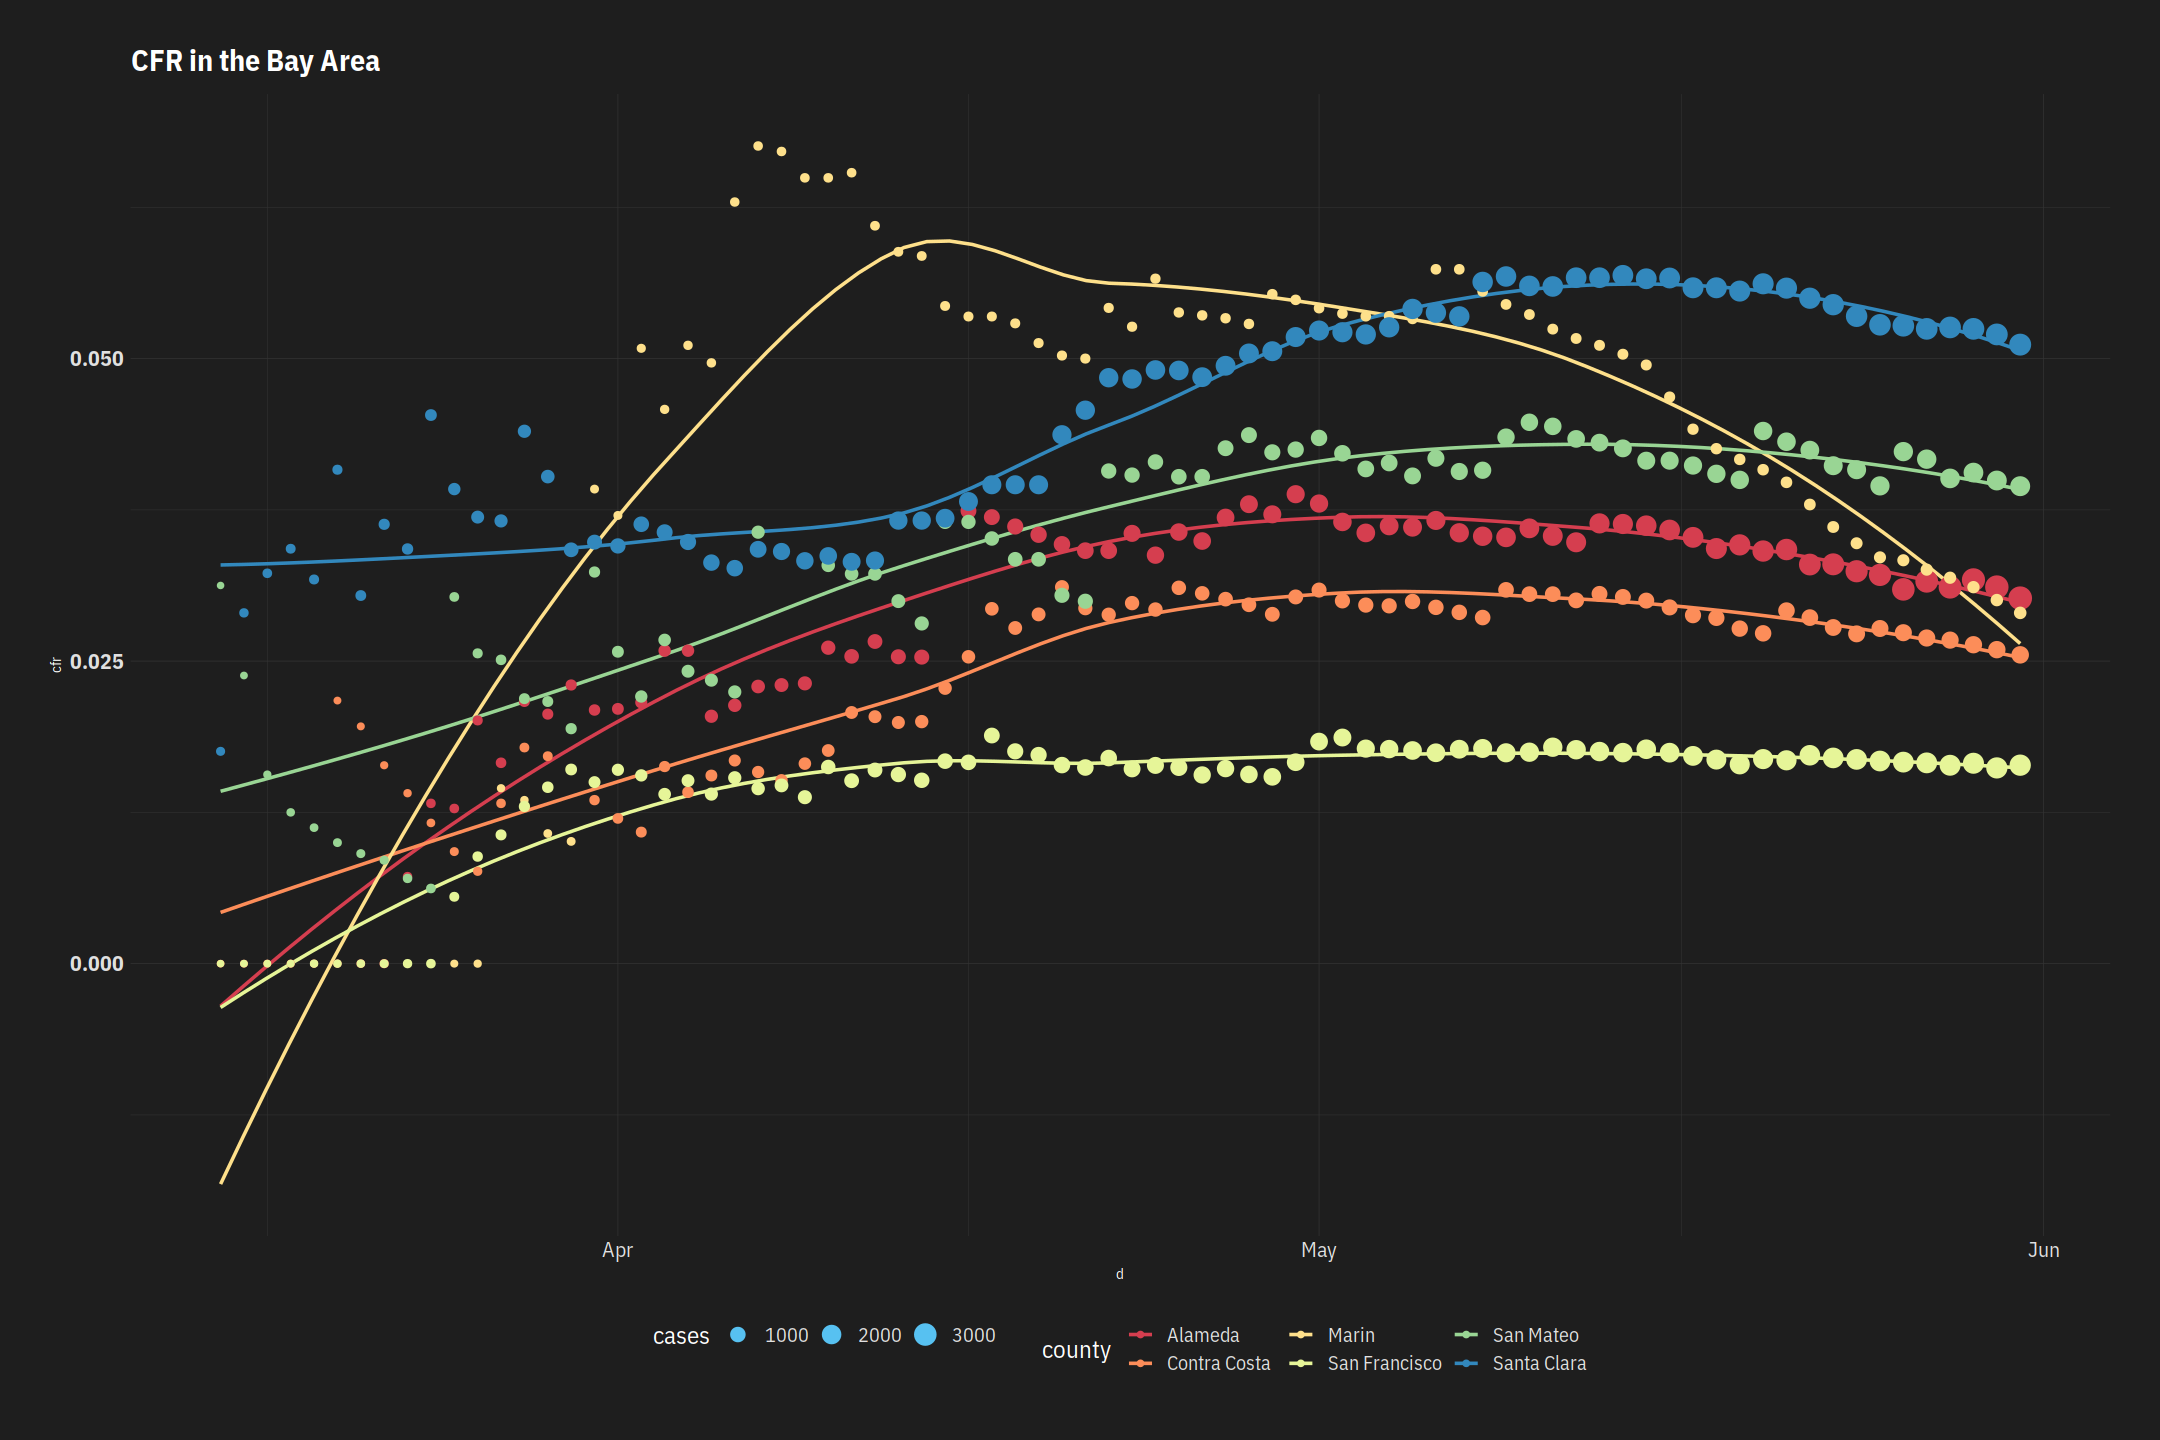

In [21]:
(cfrp = ggplot(bayrea_mar[d >= "2020-03-15"], aes(x = d, y = cfr, group = county, colour = county )) +
  geom_smooth(se = F) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("CFR in the Bay Area")
) + geom_point(aes(size = cases))